Iterative SLS example with nonlinear dynamics for the state [joint_pos, joint_vel, end_pos, end_vel] and the control [joint_acc] with a quadratic cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os


from isls import iSLS
from isls.utils import get_double_integrator_AB, plot_robot, plot_robot_base
from isls.projections import *
from isls.plot_utils import  plot_car

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

In [2]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='html5')

In [3]:
from autograd import elementwise_grad
def elementwise_jacobian2(f,x):
    return np.stack([elementwise_grad(lambda xx: f(xx)[:, j])(x) for j in range(f(x).shape[-1])], axis=1)
def elementwise_jacobian(f):
    return (lambda xx: elementwise_jacobian2(f, xx))

### Problem parameters 

In [4]:
x_dim = 4
u_dim = 2 
T = 15.
horizon = 500
N = horizon
dt = T/N
print("dt:", dt)
d = x_dim
sls = iSLS(d, u_dim, N)

dt: 0.03


#### Forward model f(x, u) and its jacobian get_AB(x, u)

In [5]:
# constants
dist  = 2.0    # dist = distance between back and front axles
import autograd.numpy as np_
def f(s, u):
    """
    s = [x y t v] = [x; y; car_angle; front_wheel_velocity]
    u = [w a]    = [front_wheel_angle; acceleration]
    """
    w = u[...,0:1] # front_wheel_angle
    a = u[...,1:2] # front wheel acceleration
    
    x = s[...,0:1]
    y = s[...,1:2]
    o = s[...,2:3] # car_angle
    v = s[...,3:4] # front wheel velocity
        
    f_ = dt*v # front wheel rolling distance
    # ins_sqrt = np_.maximum(dist**2-(np_.sin(w)*f_)**2, real_min)
    ins_sqrt = dist**2-(np_.sin(w)*f_)**2
    b = f_*np_.cos(w) + dist - np_.sqrt(ins_sqrt) # back wheel rolling distance
    
    # do = np_.arcsin(np_.clip(np_.sin(w)*f_/dist, -1., 1.))  # change in car angle
    do = np_.arcsin(np_.sin(w)*f_/dist) # change in car angle

    
    # tmp = np.sum(np.abs(np_.sin(w)*f_/dist) > 1)
    # if tmp>0:
    #     ind = np.abs(np_.sin(w)*f_/dist) > 1
    #     print( (np.abs(np_.sin(w)*f_/dist) - 1)[ind])
    
    x_ = x + b*np_.cos(o)
    y_ = y + b*np_.sin(o)
    o_ = o + do
    v_ = v + a*dt
    return np_.concatenate([x_, y_, o_, v_], axis=-1)

# Set the forward model
sls.forward_model = f

In [6]:
def f_(xu):
    x = xu[...,:d]
    u = xu[...,d:]
    return f(x,u)
jacob = elementwise_jacobian(f_)
def get_AB(x, u):
    J = jacob(np.concatenate([x,u],axis=-1))
    A = J[:,:,:d]
    B = J[:,:,d:]
    tmp = np.sum(np.isnan(A)) + np.sum(np.isnan(B))
    if tmp > 0:
        print("nan in A and B")
    return A,B

#### Task definition

In [7]:
cu  = 1e-2*np.array([1, .01])        # control cost coefficients
cu_ = np.tile(cu[None], (N,1))
cu_[-1] = 0.

pf  = np.array([.01, .01, .01,  1])      # smoothness scales for final cost
cf  = np.array([ .1,  .1,   1.,  .3])    # final cost coefficients
cf_ = np.tile(cf[None], (N,1))
cf_[:-1] = 0.

px  = np.array([.1, .1])[None]      # smoothness scales for running cost
cx  = 1e-3*np.array([1. , 1.]  )    # running cost coefficients
cx_ = np.tile(cx[None], (N,1))
cx_[-1] = 0.

def pseudo_huber(x,p):
    # smooth absolute-value function (a.k.a pseudo-Huber)
    return np_.sqrt( x**2 + p**2) - p

def cost_vec(x, u):
    # % cost function for car-parking problem
    # % sum of 3 terms:
    # % lu: quadratic cost on controls
    # % lf: final cost on distance from target parking configuration
    # % lx: running cost on distance from origin to encourage tight turns
    # control cost
    lu = np_.sum(cu * (u**2), axis=-1)
    # Final cost
    lf = cf_ @ pseudo_huber(x[-1], pf) 
    # running cost
    lx = np_.sum(cx_ * pseudo_huber(x[:,:2], px), axis=-1)
    # total cost
    
    c = lf + lu + lx
    return c

def cost(x, u):
    if x.ndim == 3:
        costs = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            costs[i] = np.sum(cost_vec(x[i], u[i]),-1)
        costs[np.isnan(costs)] = 1e6
    else:
        costs = np.sum(cost_vec(x, u),-1)
    return costs

def cost_vec_(xu):
    x = xu[...,:d]
    u = xu[...,d:]
    return cost_vec(x,u)
    
cs = elementwise_grad(cost_vec_)
Cs = elementwise_jacobian(cs)
def get_Cs(x, u):
    # Assumes there is no cost on the multiplication of x and u.
    xu = np.concatenate([x, u],-1)
    cs_ = cs(xu)
    Cs_ = Cs(xu)  
    Cs_ = 0.5*(np.transpose(Cs_, axes=(0,2,1)) + Cs_)
    cs_[np.isnan(cs_)] = 0.
    Cs_[np.isnan(cs_)] = 0.
    return cs_, Cs_

In [8]:
# Set the cost variables if non-quadratic cost
sls.cost_function = cost

### Solve the unconstrained problem

In [9]:
# initial guess
u0 = np.random.normal(size=(N, u_dim))*0.1
# u0 = np.ones((N, u_dim))*1e-1
x0 = np.array([1., 1., 3.*np.pi/2, 0])
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]

sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom

Forward pass failed, cannot improve anymore at iteration 1 .
[6.055322224302326]
Wall time: 142 ms


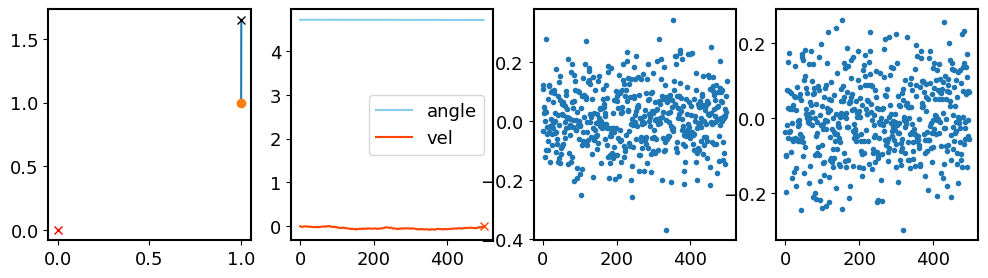

In [10]:
%%time
# Solve
dp=1
verbose=0
sls.solve_ilqr(get_AB, get_Cs, max_ilqr_iter=100, max_line_search_iter=35, dp=dp, verbose=verbose)
print(sls.cost_log)
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")


ax[1].plot(sls.x_nom[:,2], "skyblue", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", label="vel")

# ax[1].plot([N], [0], "x", color= "skyblue")
ax[1].plot([N], [0], "x", color="orangered")

ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1],".")

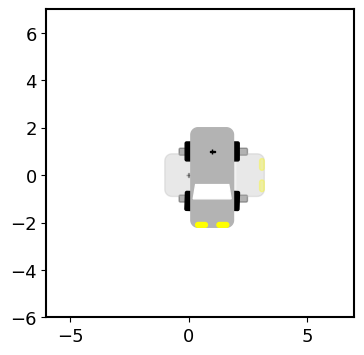

In [11]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
x_final_target = np.zeros(d)
ln, = ax.plot([], lw=2, color="k")
patches = plot_car(sls.x_nom[0], sls.u_nom[0])
patches_final = plot_car(x_final_target, np.zeros(u_dim))
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-6, 7)
    ax.set_ylim(-6, 7)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[10:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::2], interval=20, init_func=init, blit=True)


## Solve the constrained problem

### Define constraints

In [12]:
list_of_proj_u = []
list_of_proj_x = []

### Control limits
lower_u1 = -.5
upper_u1 = .5

lower_u2 = -2.

upper_u2 = 2.
def project_u(u):
    u_ = u.reshape(N,u_dim).copy()
    u_[:, 0:1] = project_bound(u_[:, 0:1], lower_u1, upper_u1)
    u_[:, 1:2] = project_bound(u_[:, 1:2], lower_u2, upper_u2)
    return u_.flatten()
list_of_proj_u += [project_u]

In [13]:
u0 = np.random.normal(size=(N, u_dim))*0.1
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]

In [14]:
sls.reset()
sls.nominal_values = x_nom, u_nom
sls.cost

5.999002977404557

Iteration number  0 iLQR cost:  5.538053312806182
Iteration number  1 iLQR cost:  5.409297863821515
Iteration number  2 iLQR cost:  5.3359818049102
Iteration number  3 iLQR cost:  5.318693449950853
Iteration number  4 iLQR cost:  5.228632717264897
Iteration number  5 iLQR cost:  5.1608168742875025
Iteration number  6 iLQR cost:  5.07631893781912
Iteration number  7 iLQR cost:  4.952766212933527
Iteration number  8 iLQR cost:  4.887982307078275
Iteration number  9 iLQR cost:  4.847834880588789
Iteration number  10 iLQR cost:  4.7675925723106065
Iteration number  11 iLQR cost:  4.447644164767486
Iteration number  12 iLQR cost:  4.069757693783597
Iteration number  13 iLQR cost:  3.948886650004621
Iteration number  14 iLQR cost:  3.873361837220125
Iteration number  15 iLQR cost:  3.832529045738168
Iteration number  16 iLQR cost:  3.7556360245871687
Iteration number  17 iLQR cost:  3.64138591980854
Iteration number  18 iLQR cost:  3.3512580245644727
Iteration number  19 iLQR cost:  2.930277

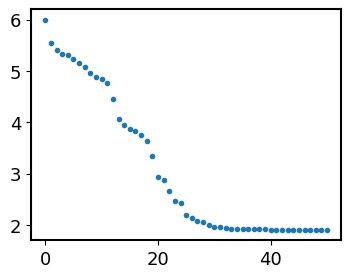

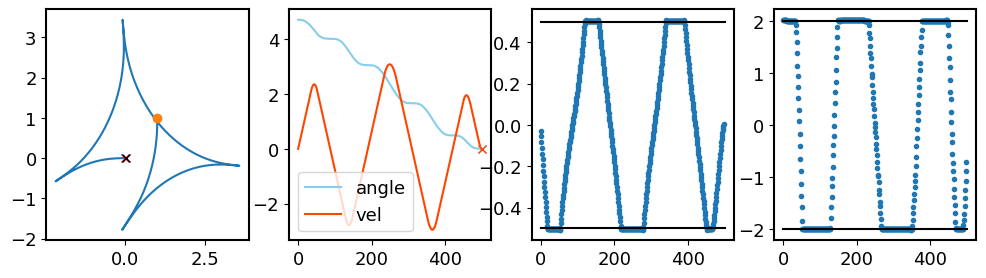

In [15]:
%%time
Rr = np.diag([1e-1, 1e-2])
alpha = 1. # relaxation parameter for ADMM
k_max = 50
log = sls.ilqr_admm(get_AB, get_Cs=get_Cs, list_of_proj_x=list_of_proj_x, list_of_proj_u=list_of_proj_u, max_admm_iter=5,
                        max_line_search=50, rho_x=None, rho_u=Rr, alpha=alpha, k_max=k_max, threshold=1e-3, verbose=False, log=True)
plt.plot(sls.cost_log,".")
# plt.plot(log)
# print(sls.x_nom[-1])
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")


ax[1].plot(sls.x_nom[:,2], "skyblue", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", label="vel")

ax[1].plot([N], [0], "x", color= "skyblue")
ax[1].plot([N], [0], "x", color="orangered")

ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1],".")
lower_us = [lower_u1, lower_u2]
upper_us = [upper_u1, upper_u2]

for i in range(2):
    ax[2+i].plot([0,N],[lower_us[i]]*2, "k")
    ax[i+2].plot([0,N],[upper_us[i]]*2, "k")

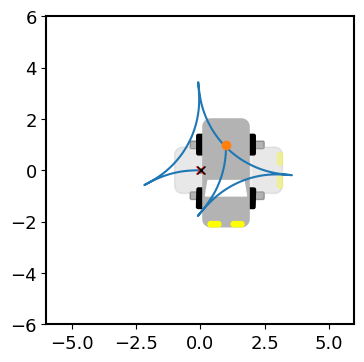

In [25]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
x_final_target = np.zeros(d)
ln, = ax.plot([], lw=2, color="k")
patches = plot_car(sls.x_nom[0], sls.u_nom[0])
patches_final = plot_car(x_final_target, np.zeros(u_dim))
ax.plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax.plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax.plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
ax.plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[10:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::2], interval=20, init_func=init, blit=True)


In [27]:
ani.save('animation.gif', writer='imagemagick', fps=60)